In [1]:
import uproot
import numpy as np
import ROOT
import itertools
from array import array
ROOT.gROOT.SetStyle('ATLAS')
import time
import matplotlib.pyplot as plt

FONT_SIZE = 0.05
def draw_note(x, y, text, size=.05, font=42):
    l = ROOT.TLatex()
    l.SetTextColor(1)
    l.SetTextFont(font)
    l.SetTextSize(size)
    l.SetNDC()
    l.DrawLatex(x, y, text)

def atlas_label(x, y, text=None, color=1):
    draw_note(x, y, r"#bf{#it{ATLAS}} " + text)

def divide0(n, d):
    return n / d if d else 0

def get_markers():
    return itertools.cycle([22,21,33,29,30,31,32,34,35])

def get_colors():
    return itertools.cycle([ROOT.kBlack, ROOT.kAzure+6, ROOT.kViolet+8, ROOT.kRed, ROOT.kGreen+1, ROOT.kOrange -3])

Welcome to JupyROOT 6.22/06


In [2]:
# https://cds.cern.ch/record/2267569/files/ATL-COM-PHYS-2017-701.pdf
# Step# 2: A number of rDV bins are also defined (not as per the radial region divisions). Total number of
# rDV bins is 15. Each bin has a uniform width of 20 mm except for the last bin (# 15), which is 16 mm wide.
# The rDV region covered in total is 4-300 mm
dvr_bins = [4,  24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284] #for higher pt low stats at low dvr
dvr_bins = [0,      44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284]
dvr_bins = [0,          64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284]
dvr_bins_lowpt =  [0,          64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284]
dvr_bins_highpt = [0,              84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284]

vtx_alg = 'VSI' 
vtx_alg = 'VSI_LRTR3_1p0' 

output_dir = "/data/hnl/KShort/plots/"
hscale = 0.75
# int note bins # why start at 4? 
# I get it the IBL, but what about closer vertices?
# dvr_bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300] # sensible bins?

def make_comparison_plot(pt_bin, pt_idx):
    # define markers and colors in never ending cycle
    hist_markers = get_markers()
    hist_colors = get_colors()
    
    tree_name = f'{vtx_alg}_ntuples_mass'
    var = 'DV_r'
    cutvar = f'DV_sum_track_pt'
    cutmin = pt_bin[0]
    cutmax = pt_bin[1]
    mass_cut_min = .4977 - .01  # kshort mass +/- epsilon
    mass_cut_max = .4977 + .01
    if cutmin >= 25:
        dvr_bins = dvr_bins_highpt
    else:
        dvr_bins = dvr_bins_lowpt

    bin_string = "{}_{}".format(cutmin, cutmax).replace('.', 'p')
    if cutmax == np.inf: cutmax = ROOT.RooNumber.infinity()
    # Open file
    tfiles = {'data': ROOT.TFile('/data/hnl/KShort/histograms/data18/CR_histograms_data_kshort.root'),
              'mc': ROOT.TFile('/data/hnl/KShort/histograms/dijet_mc16e/CR_histograms_mc_kshort.root')}
    # Load tree from file
    ttree = {'data': tfiles['data'].Get(tree_name),
             'mc':  tfiles['mc'].Get(tree_name)}

    # Prepare canvas
    c = None
    c = ROOT.TCanvas("c"+bin_string, "", int(1200*hscale), int(800*hscale))

    # Upper plot will be in pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    # pad1.SetGridx();           # Vertical grid
    pad1.Draw()                  # Draw the upper pad: pad1
 
    # lower plot will be in pad 2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.4)
    # pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw('goff')
    
    #########################
    # Main plot
    #########################
    pad1.cd() # pad1 becomes the current pad
    
    # Define histograms
    rdv = {'data': ROOT.TH1D('rdv_data'+bin_string,'Displaced Vertex Radius', len(dvr_bins)-1, array('d', dvr_bins)),
           'mc': ROOT.TH1D('rdv_mc'+bin_string,'Displaced Vertex Radius', len(dvr_bins)-1, array('d', dvr_bins))}
    
    # Fill histograms from ntuple. goff indicates not to draw.
    print(f'{var}>>rdv_data'+bin_string, f'{cutmax}>{cutvar}>{cutmin}', sep=',\t')
    ttree['data'].Draw(f'{var}>>rdv_data'+bin_string,
                       f'{cutvar}>{cutmin} && {cutvar}<{cutmax} \
                       && DV_mass > {mass_cut_min} &&  DV_mass < {mass_cut_max}',
                       'goff')
    ttree['mc'].Draw(f'{var}>>rdv_mc'+bin_string,
                     f'{cutvar}>{cutmin} && {cutvar}<{cutmax} \
                       && DV_mass > {mass_cut_min} &&  DV_mass < {mass_cut_max}',
                     'goff')

    print('dijet entries: ', int(rdv['mc'].GetEntries()))
    print('data entries:  ', int(rdv['data'].GetEntries()))
    
    # Set draw properties
    for h in rdv.values():
        # Histogram properties
        h.SetMarkerSize(1.5*hscale)
        h.SetLineWidth(int(3*hscale))
        hcolor = next(hist_colors)
        h.SetLineColor(hcolor)
        h.SetMarkerColor(hcolor)
        hmarker = next(hist_markers)
        h.SetMarkerStyle(hmarker)
        # X axis
        x_ax = h.GetXaxis()
        x_ax.SetTitle("Displaced vertex radius [mm]")
        x_ax.SetLabelSize(0)
        x_ax.SetTitle(var)
        # Y axis
        y_ax = h.GetYaxis()
        y_ax.SetTitle("Vertices (normalized to first bin)")
        y_ax.SetMaxDigits(6);
        y_ax.SetTitleOffset(1.0)
        y_ax.SetRangeUser(0,1);
        y_ax.SetLabelFont(42)
        y_ax.SetLabelSize(FONT_SIZE);   
        y_ax.SetTitleFont(42)
        y_ax.SetTitleSize(FONT_SIZE*1.2)

    for h in rdv.values():
        # Normalize the histograms to unity
        scale = divide0(1, h.Integral())
        h.Scale(scale)
    
    # Normalize to the first bin
    # We do this assuming that the vertices closest to the interaction point 
    # are most reliable between data and MC
    first_bin_ratio = divide0( # safe divide
        rdv['data'].GetBinContent(1), # bin 0 is underflow
        rdv['mc'].GetBinContent(1)) 
    rdv['mc'].Scale(first_bin_ratio)

    # Draw the histograms
    rdv['mc'].Draw('E0 HIST SAME')
    rdv['data'].Draw('E0 HIST SAME')
    
    # format legend
    x = 0.6
    y = 0.7
    dy = .07
    leg = ROOT.TLegend(x, y, x+.3, y+0.2)
    leg.SetTextSize(0.05)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    leg.AddEntry(rdv['data'], 'Data', "lp")
    leg.AddEntry(rdv['mc'], 'Dijet JZXW', "lp")
    leg.Draw("SAME")
    draw_note(x, y-dy, f'Vertexing: {vtx_alg_string}')
    draw_note(x, y-2*dy, f'#Sigma p_{{T}} bin: [{cutmin}, {cutmax}] GeV')
    draw_note(x, y-3*dy, 'Selected K_{S}^{0}')
    atlas_label(x-.2,y+dy, 'Internal')
    

    #########################
    # Ratio plot
    #########################
    pad2.cd() # pad2 becomes the current pad
    
    hist_markers = get_markers()
    hist_colors = get_colors()
    hmarker = next(hist_markers)
    hcolor = next(hist_colors)
    # Define the ratio plot
    h3 = rdv['data'].Clone('h3');
    h3.SetLineColor(hcolor);
    h3.SetMarkerSize(1.5*hscale)
    h3.SetLineWidth(int(3*hscale))
    h3.SetMarkerColor(hcolor)
    h3.SetMarkerStyle(hmarker);
    h3.SetMinimum(0.3);  # Define Y ..
    h3.SetMaximum(1.7); # .. range
    # h3.Sumw2();
    # h3.SetStats(0);      # No statistics on lower plot
    h3.Divide(rdv['mc']); # This takes in to account uncertainties in both MC and data histogrmas
    # TODO could make a clone of the MC histogram with 0 uncertainties (setbinerror 0)
    max_bin_content = h3.GetBinContent(h3.GetMaximumBin())
    min_bin_content = h3.GetBinContent(h3.GetMinimumBin())
    # h3.SetMaximum(1.4 if max_bin_content > 1.3 else max_bin_content + .1);
    # h3.SetMinimum(min_bin_content - .1);
    hline = ROOT.TLine(h3.GetBinCenter(h3.FindFirstBinAbove()), 1, h3.GetBinCenter(h3.FindLastBinAbove()), 1)
    hline.SetLineColor(next(hist_colors))
    pad2.SetFillStyle(0)
    h3.Draw() # Draw the axes 
    hline.Draw("same")
    h3.Draw("hist same") # Draw the ratio plot 
    h3.Draw("e same") # Draw the ratio plot errors

    # Y axis ratio plot settings
    h3.GetYaxis().SetTitle("ratio #frac{data}{mc}")
    h3.GetYaxis().SetNdivisions(505)
    h3.GetYaxis().SetTitleSize(FONT_SIZE*4)
    h3.GetYaxis().SetTitleFont(42)
    h3.GetYaxis().SetTitleOffset(0.3)
    h3.GetYaxis().SetLabelFont(42) 
    h3.GetYaxis().SetLabelSize(FONT_SIZE*3)
    # X axis ratio plot settings
    h3.GetXaxis().SetTitle("Displaced vertex radius [mm]")
    h3.GetXaxis().SetTitleSize(FONT_SIZE*4);
    h3.GetXaxis().SetTitleFont(42);
    h3.GetXaxis().SetTitleOffset(0.9);
    h3.GetXaxis().SetLabelFont(42); 
    h3.GetXaxis().SetLabelSize(FONT_SIZE*3);  

    c.Draw()
    c.SaveAs(f'{output_dir}vertex_comparison_{bin_string}.png')
    
    print(int(h3.GetEntries()))
    # fill 2d plot
    for i in range(1, int(h3.GetEntries())):
        h2d.SetBinContent(i, pt_idx, h3.GetBinContent(i))


# pt_bins = [2, 2.5, 3, 4, 6, 8, 10, np.inf] # old paper bins. too low.
pt_bins = [2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, np.inf] # What we want, but not really enough stats.

# Set up 2d plot
c2 = ROOT.TCanvas("c2", "2D plot", int(1200*hscale), int(800*hscale))
c2.SetRightMargin(0.1)
h2d = ROOT.TH2D("h2","2D plot",
               len(dvr_bins+[300])-1, array('d', dvr_bins+[300]),
               len(pt_bins)-1, array('d', pt_bins[0:-1]+[pt_bins[-2]+1]))
h2d.GetXaxis().SetTitle(f"Displaced vertex radius [mm]")
h2d.GetYaxis().SetTitle(f"Track #Sigma p_{{T}} [GeV]")

# Run plotting over all sum pt bins

for i, pt_bin in enumerate(zip(pt_bins, pt_bins[1:]), start=1):
    make_comparison_plot(pt_bin, i)

# Draw 2d plot
h2d.SetMaximum(2)
h2d.SetMinimum(0)
h2d.Draw("colz SAME TEXT45")
ROOT.gStyle.SetPaintTextFormat("4.2f");
# Cover top bin and call it overflow
# box = ROOT.TBox(-10,10.5,3,11.2)
# box.SetFillColor(ROOT.kWhite)
# box.Draw("SAME")
# draw_note(.08,.91,"overflow", size = .033)
atlas_label(.65,.74, 'Internal')
draw_note(.65,.60,vtx_alg_string)

# c2.Draw()
c2.SaveAs(f'{output_dir}vertex_comparison_2D.png')

DV_r>>rdv_data2_4,	4>DV_sum_track_pt>2


KeyboardInterrupt: 

In [7]:
# Get entries in 2d hist
# for i, pt in enumerate(pt_bins):
#     print('pt', pt)
#     for j, r in enumerate(dvr_bins):
#         print('dvr', r)
#         print(h2d.GetAt(h2d.GetBin(j,i)))


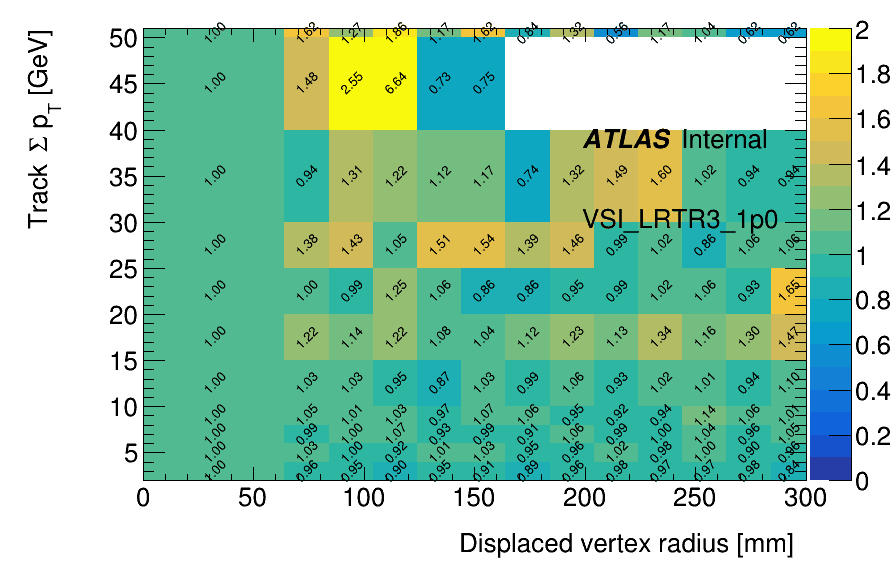

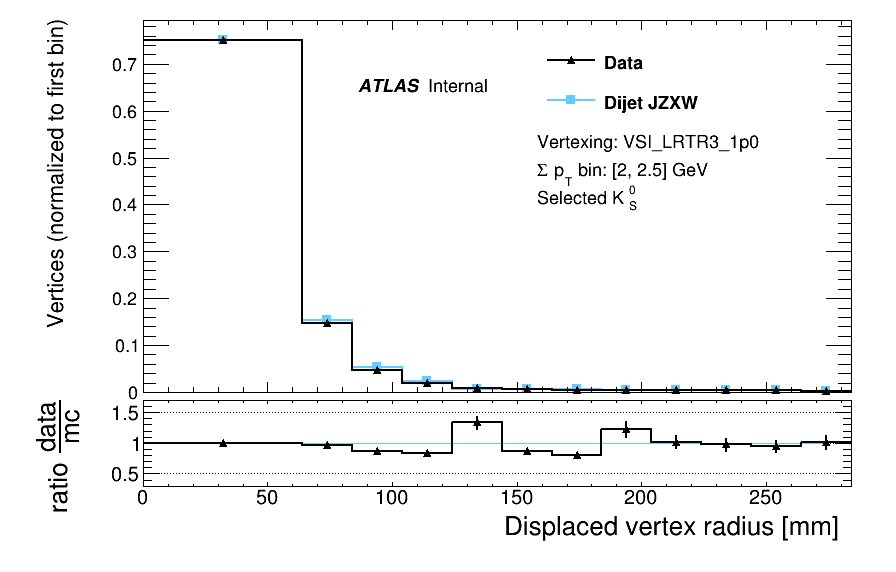

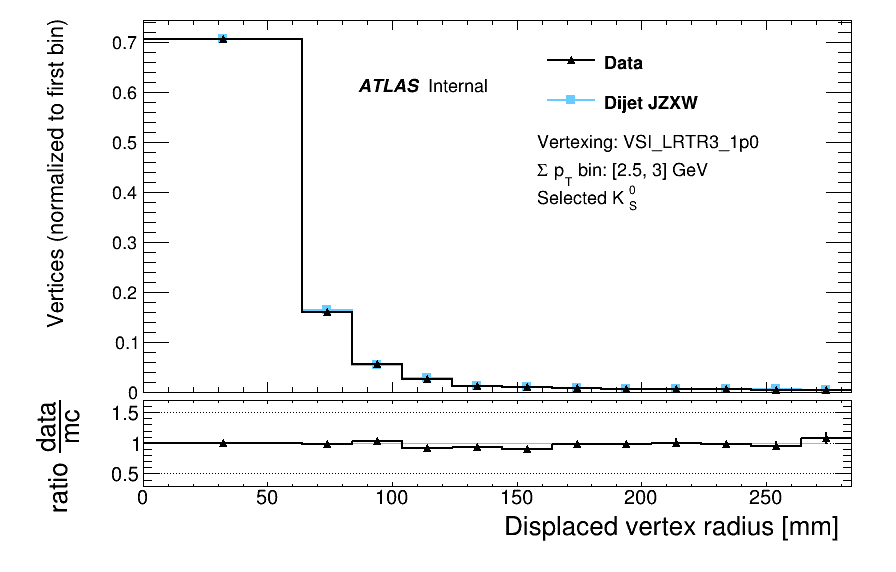

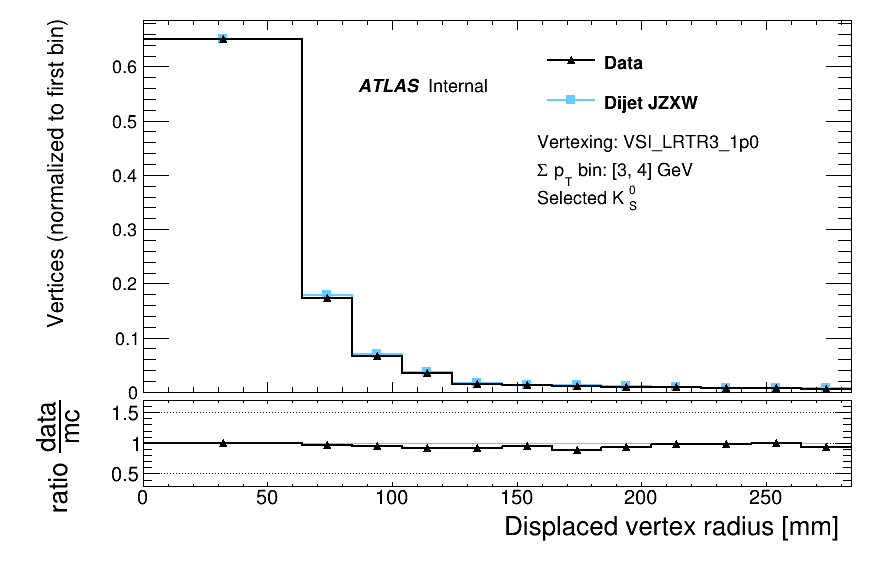

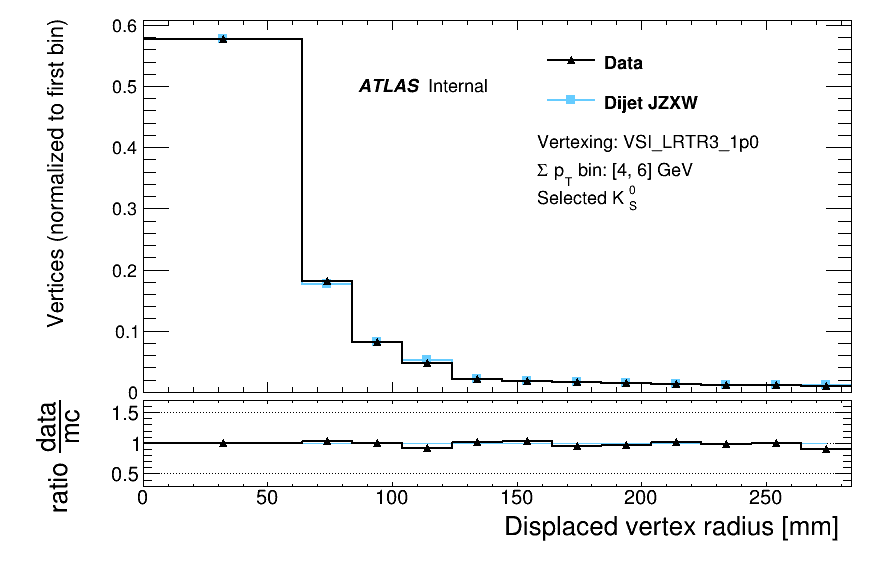

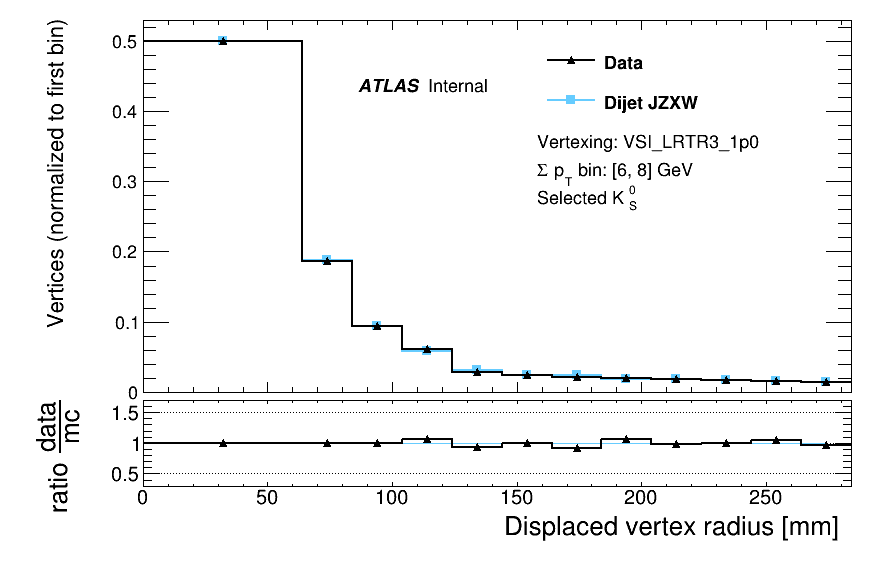

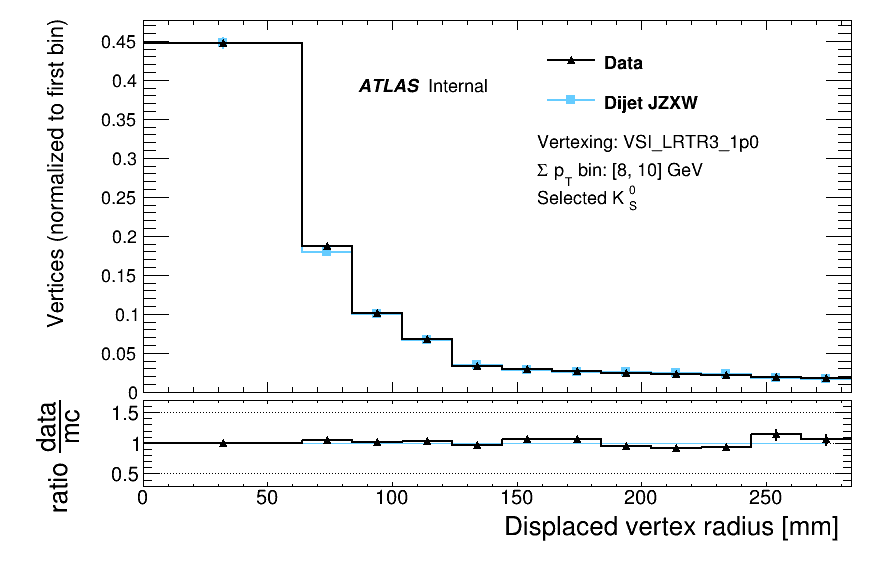

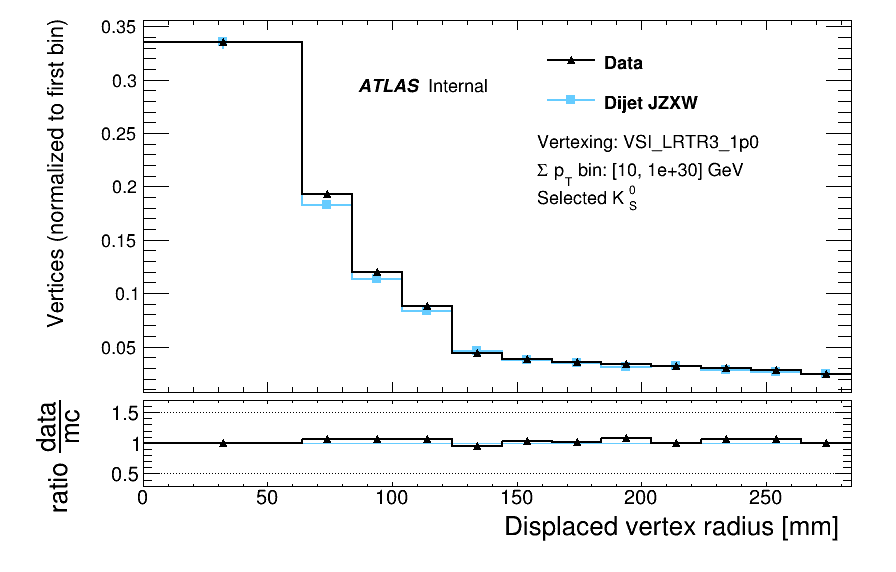

In [8]:
from IPython.display import Image, display
display(Image("/data/hnl/KShort/plots/vertex_comparison_2D.png"))
# display(Image("/data/hnl/KShort/SUSY15/plots/vertex_comparison_0_2.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_2_2p5.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_2p5_3.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_3_4.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_4_6.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_6_8.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_8_10.png"))
display(Image("/data/hnl/KShort/plots/vertex_comparison_10_inf.png"))

In [3]:
# Setting up pyplot
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)


#### It doesn't look like we're particularly sensitive to J/Psi mesons with this vertexing
mass_{J/Psi} = 3.097 GeV

mass_{K_0} = 0.497 GeV

24552020


<AxesSubplot:>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


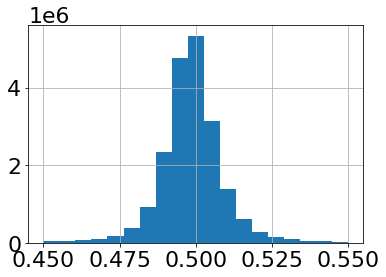

In [4]:
data_ntuple = uproot.open('/data/hnl/KShort/histograms/data18/CR_histograms_data_kshort.root')
dijet_ntuple = uproot.open('/data/hnl/KShort/histograms/dijet_mc16e/CR_histograms_mc_kshort.root')
# print(data_ntuple['ntuples_mass_VSI_LRTR3_1p0'].keys())
# vertex_mass_array = data_ntuple['outTree'].pandas.df([f'secVtx_VSI{augmentation}_mass']).explode(f'secVtx_VSI{augmentation}_mass').to_numpy()

vertex_container = 'VSI_LeptonsMod_LRTR3_1p0_ntuples_mass'
vertex_container = 'VSI_Leptons_ntuples_mass'
vertex_container = 'VSI_LRTR3_1p0_ntuples_mass'
vertex_container = 'VSI_ntuples_mass'

df = data_ntuple[vertex_container].pandas.df()
print(len(df))
df.DV_mass.hist(bins=np.linspace(0.45,0.55,20))

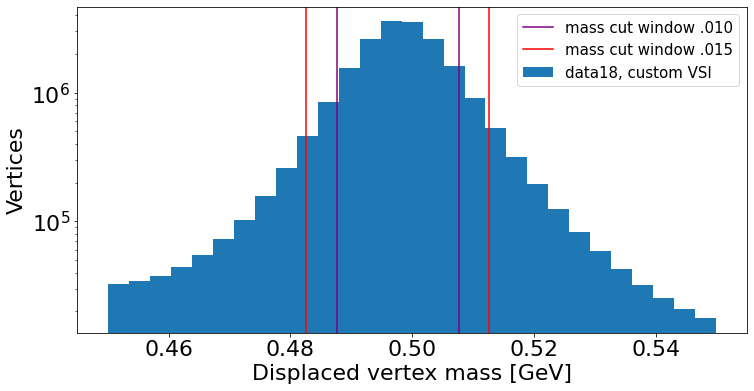

In [13]:
# J/Psi bins
bins = np.linspace(3.0, 3.2, 50) 
vert_line=3.096916
# K-Short bins
bins = np.linspace(.45, .55, 30) 
vert_line=.497648

fig = plt.figure(figsize=[12,6])
ax = plt.axes()
vertex_mass_array = df.query('DV_num_trks == 2')['DV_mass'].array
h = plt.hist(vertex_mass_array, log=True, bins=bins, label='data18, custom VSI')
plt.axvline(x=vert_line+.01, color='purple', label='mass cut window .010')
plt.axvline(x=vert_line+.015, color='red', label='mass cut window .015')
ax.legend(fontsize=15)
plt.axvline(x=vert_line-.01, color='purple', label='mass cut window')
plt.axvline(x=vert_line-.015, color='red', label='mass cut window')
ax.set_xlabel('Displaced vertex mass [GeV]')
ax.set_ylabel('Vertices');


It makes sense that we have nothing filled in the 0-2 bin since there is a cut on tracks below 2 GeV

In [44]:
ntup_all_DV_sum_track_pt = data_histograms['VSI_2']['ntuples_all_VSI_2'].array('ntup_all_DV_sum_track_pt')
fig = plt.figure(figsize=[10,5])
ax = plt.axes()
h = plt.hist(ntup_all_DV_sum_track_pt, log=False, bins=np.linspace(0.0,10,30), density=1)
ax.set_xlabel('Track $p_{T}$ [GeV]')
ax.set_ylabel('Tracks (normalized)');

AttributeError: 'DataFrame' object has no attribute 'array'

## Cutflow

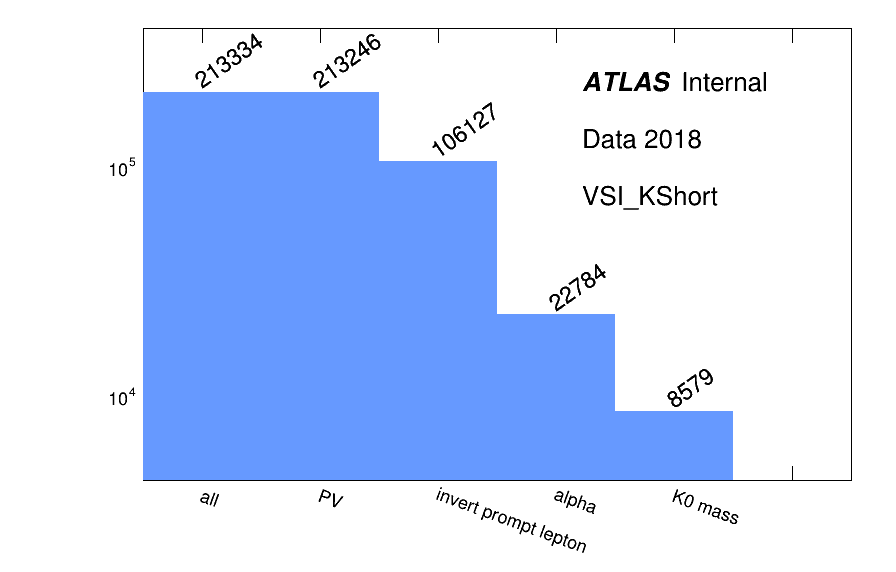

In [60]:
data_file = ROOT.TFile('/data/hnl/KShort/SUSY15/data_histograms/histograms_data_kshort.root')
data_cutflow = data_file.Get('VSI_2/CutFlow/CutFlow_VSI_2')
c3 = ROOT.TCanvas("c3", "2D plot", int(1200*hscale), int(800*hscale))
c3.SetLogy()
# data_cutflow.GetYaxis().SetRangeUser(0.1,ymax_cutflow*1000)
data_cutflow.GetXaxis().SetRangeUser(0, 5)
data_cutflow.SetFillColor(ROOT.kAzure-4)
data_cutflow.SetLineWidth(0)
data_cutflow.GetYaxis().SetTickLength(0.)
data_cutflow.GetXaxis().SetLabelSize(.05)
data_cutflow.GetXaxis().SetLabelOffset(.01)
data_cutflow.SetMarkerSize(2.2)

x = 0.5
y = 0.5
dy = 0.06


data_cutflow.Draw("HIST TEXT35")
atlas_label(.65,.84, 'Internal')
draw_note(.65,.74,"Data 2018")
draw_note(.65,.64,"VSI_KShort")
data_cutflow.Draw("HIST TEXT35 SAME")


c3.Draw()

# Applying the alpha cut

In [189]:
# With control region and alpha cut
kshort = uproot.open('/data/hnl/KShort/mc16_13TeV.361024.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ4W.merge.DAOD_RPVLL.e3668_s3126_r10848_r10706_histograms/CR_histograms_mc_kshort.root')
dv_mass_vsi = kshort[f'VSI_ntuples_sel'].pandas.df(['DV_mass']).to_numpy()
dv_mass_vsi_leptons = kshort[f'VSI_Leptons_ntuples_sel'].pandas.df(['DV_mass']).to_numpy()

In [ ]:
# No control region
data_ntuple = uproot.open('/data/hnl/KShort/mc16_13TeV.361024.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ4W.merge.DAOD_RPVLL.e3668_s3126_r10848_r10706_ntuple/testRun/data-tree/files.root')
dv_mass_vsi = data_ntuple['outTree'].pandas.df([f'secVtx_VSI_mass']).explode(f'secVtx_VSI_mass').to_numpy()
dv_mass_vsi_leptons = data_ntuple['outTree'].pandas.df([f'secVtx_VSI_Leptons_mass']).explode(f'secVtx_VSI_Leptons_mass').to_numpy()

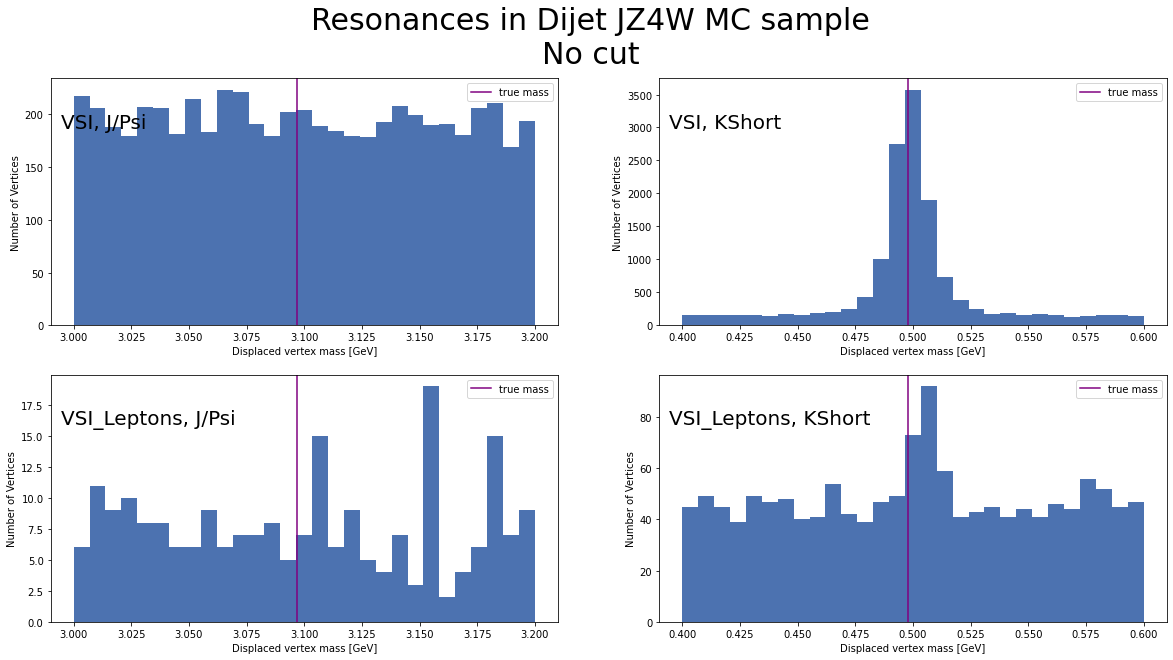

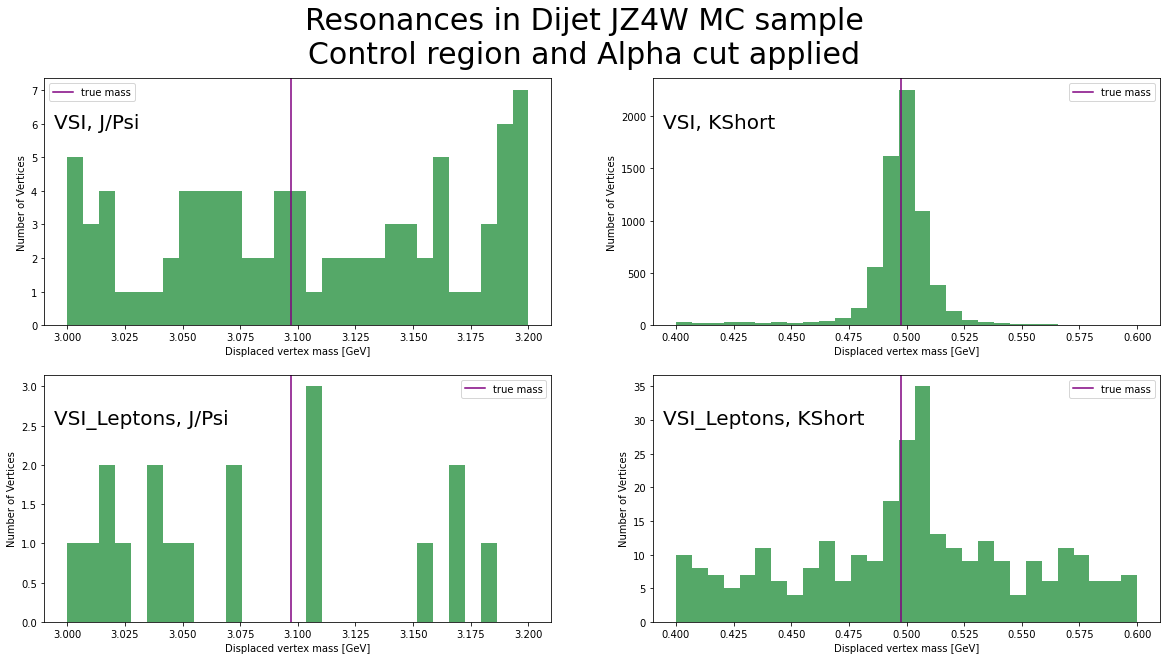

In [200]:
def plot_resonances(dv_mass_vsi, dv_mass_vsi_leptons, title, color='#4C72B0', bins=30):
    jpsi_bins = np.linspace(3.0, 3.2, bins) # J/Psi bins
    kshort_bins = np.linspace(.4, .6, bins) # K-Short bins

    fig = plt.figure(figsize=[20,10])
    fig.tight_layout()
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 2, 3)
    ax4 = plt.subplot(2, 2, 4)

    for ax, dv_mass, bins, vert, legend_label in zip(
        [ax1, ax2, ax3, ax4],
        [dv_mass_vsi, dv_mass_vsi, dv_mass_vsi_leptons, dv_mass_vsi_leptons],
        [jpsi_bins, kshort_bins, jpsi_bins, kshort_bins],
        [3.096916, .497648, 3.096916, .497648],
        ['VSI, J/Psi', 'VSI, KShort', 'VSI_Leptons, J/Psi', 'VSI_Leptons, KShort']
        ):

        h = ax.hist(dv_mass, bins=bins, color=color)
        ax.axvline(x=vert, color='purple')
        ax.set_xlabel('Displaced vertex mass [GeV]')
        ax.set_ylabel('Number of Vertices')
        ax.legend(['true mass'])
        ax.text(.02, .8, legend_label, fontsize=20, transform=ax.transAxes)

    fig.suptitle(title, fontsize=30);

# No control region
data_ntuple = uproot.open('/data/hnl/KShort/mc16_13TeV.361024.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ4W.merge.DAOD_RPVLL.e3668_s3126_r10848_r10706_ntuple/testRun/data-tree/files.root')
dv_mass_vsi = data_ntuple['outTree'].pandas.df([f'secVtx_VSI_mass']).explode(f'secVtx_VSI_mass').to_numpy()
dv_mass_vsi_leptons = data_ntuple['outTree'].pandas.df([f'secVtx_VSI_Leptons_mass']).explode(f'secVtx_VSI_Leptons_mass').to_numpy()
plot_resonances(dv_mass_vsi, dv_mass_vsi_leptons, "Resonances in Dijet JZ4W MC sample\nNo cut")

# With control region and alpha cut
kshort = uproot.open('/data/hnl/KShort/mc16_13TeV.361024.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ4W.merge.DAOD_RPVLL.e3668_s3126_r10848_r10706_histograms/CR_histograms_mc_kshort.root')
dv_mass_vsi = kshort[f'VSI_ntuples_sel'].pandas.df(['DV_mass']).to_numpy()
dv_mass_vsi_leptons = kshort[f'VSI_Leptons_ntuples_sel'].pandas.df(['DV_mass']).to_numpy()
plot_resonances(dv_mass_vsi, dv_mass_vsi_leptons, "Resonances in Dijet JZ4W MC sample\nControl region and Alpha cut applied", color='#55A868')


# pt distributions

<AxesSubplot:>

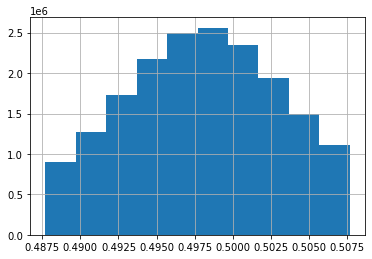

In [10]:
data_tree = uproot.open('/data/hnl/KShort/histograms/data18/CR_histograms_data_kshort.root')
data_df = data_tree['VSI_LRTR3_1p0_ntuples_mass'].pandas.df(['DV_pt', 'DV_sum_track_pt', 'DV_mass'])
data_df = data_df.query('.5077 > DV_mass > .4877')
data_df['DV_mass'].hist()

<AxesSubplot:>

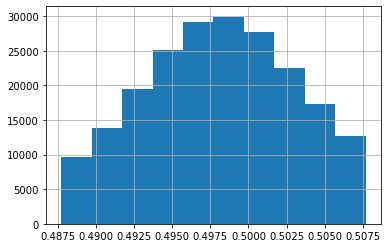

In [11]:
dijet_tree = uproot.open('/data/hnl/KShort/histograms/dijet_mc16e/CR_histograms_mc_kshort.root')
dijet_df = dijet_tree['VSI_LRTR3_1p0_ntuples_mass'].pandas.df(['DV_pt', 'DV_sum_track_pt', 'DV_mass'])
dijet_df = dijet_df.query('.5077 > DV_mass > .4877')
dijet_df['DV_mass'].hist()

NameError: name 'data_df' is not defined

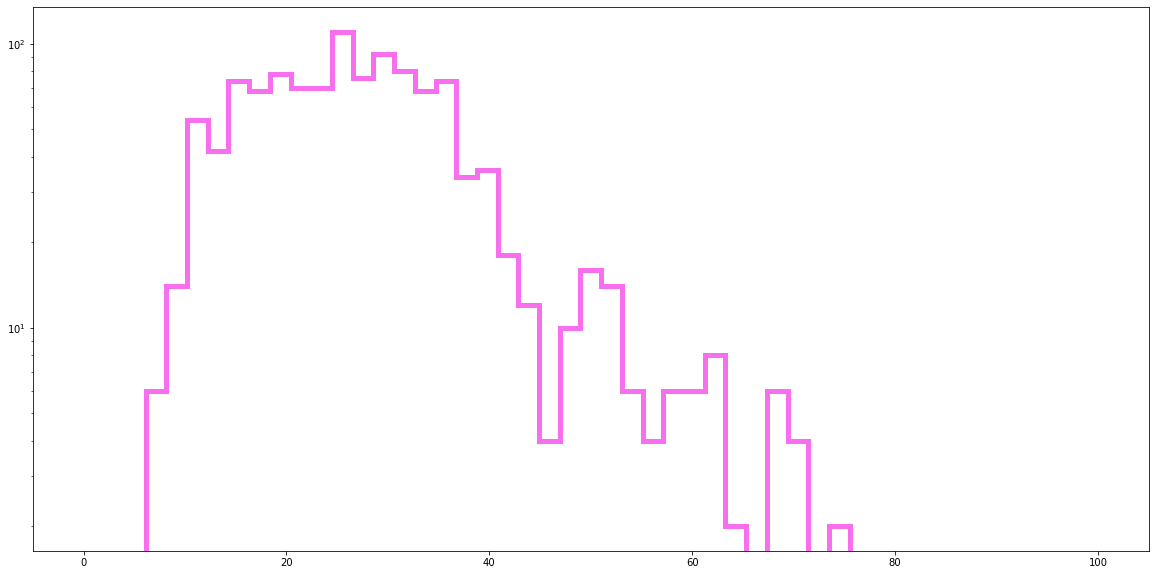

In [9]:
fig = plt.figure(figsize=[20,10])

hist_options = {
    'histtype': 'step',
    'linewidth': 5,
    'density': False,
    'bins': np.linspace(0,100,50),
    'log': True,

}
# pt_bins = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]

    
# Signal
# hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_uuu_5G_10mm/histograms_mc16e_5G_10mm_uuu.root')
# plt.hist(
#     hnl_tree['VSI_LRTR3_1p0_ntuples_DVtype'].pandas.df('DV_pt')['DV_pt'], 
#     label='signal (uuu 5GeV 10mm)',
#     color='#6f76f7',
#     **hist_options);

hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_uuu_10G_10mm/histograms_mc16e_10G_10mm_uuu.root')
plt.hist(
    hnl_tree['VSI_LRTR3_1p0_ntuples_LNC_DVtype'].pandas.df('DV_pt')['DV_pt'].append(
    hnl_tree['VSI_LRTR3_1p0_ntuples_LNC_DVtype'].pandas.df('DV_pt')['DV_pt']) , 
    label='HNL signal (uuu 10GeV 10mm)',
    color='#f76fee',
    **hist_options);

# hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_uuu_20G_10mm/histograms_mc16e_20G_10mm_uuu.root')
# plt.hist(
#     hnl_tree['VSI_LRTR3_1p0_ntuples_DVtype'].pandas.df('DV_pt')['DV_pt'], 
#     label='signal (uuu 20GeV 10mm)',
#     color='#f76f76',
#     **hist_options);


# hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_20G_1mm/histograms_mc16e_20G_1mm_uuu.root')
# plt.hist(
#     hnl_tree['VSI_LRTR3_1p0_ntuples_DVtype'].pandas.df('DV_pt')['DV_pt'], 
#     label='signal (uuu 20GeV 1mm)',
#     color='#f76f76',
#     linestyle=':',
#     **hist_options);


# hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_20G_100mm/histograms_mc16e_20G_100mm_uuu.root')
# plt.hist(
#     hnl_tree['VSI_LRTR3_1p0_ntuples_DVtype'].pandas.df('DV_pt')['DV_pt'], 
#     label='signal (uuu 20GeV 100mm)',
#     color='#f76f76',
#     linestyle='-.',
#     **hist_options);

plt.hist(
    data_df['DV_pt'],
    label='data (KShort selection)',
    color='black',
    **hist_options);
# Kaon
plt.hist(
    dijet_df['DV_pt'],
    label='dijet (KShort selection)',
    color='#709af8',
    **hist_options);

for pt_bin in pt_bins:
    plt.axvline(x=pt_bin, linewidth=2, linestyle=':', color='r')
plt.axvline(x=pt_bin, linewidth=2, linestyle=':', color='r', label='bin edge')


plt.xlabel('DV pT [GeV]', fontsize=40)
plt.ylabel('num vertices', fontsize=40)
plt.title('Comparing displaced vertex pT', fontsize=40)
plt.legend();

In [244]:
hnl_tree = uproot.open('/data/hnl/forRobin/VSILepMod_uuu_10G_10mm/histograms_mc16e_10G_10mm_uuu.root')
hnl_tree.keys()

[b'VSI_LRTR3_1p0_ntuples_LNC_DVtype;1',
 b'VSI_LRTR3_1p0_ntuples_LNV_DVtype;1',
 b'VSI_LRTR3_1p0;1',
 b'VSI_LeptonsMod_LRTR3_1p0_ntuples_LNC_DVtype;1',
 b'VSI_LeptonsMod_LRTR3_1p0_ntuples_LNV_DVtype;1',
 b'VSI_LeptonsMod_LRTR3_1p0;1',
 b'VSI_ntuples_LNC_DVtype;1',
 b'VSI_ntuples_LNV_DVtype;1',
 b'VSI;1',
 b'VSI_Leptons_ntuples_LNC_DVtype;1',
 b'VSI_Leptons_ntuples_LNV_DVtype;1',
 b'VSI_Leptons;1',
 b'VSI_Leptons_LRTR3_1p0_ntuples_LNC_DVtype;1',
 b'VSI_Leptons_LRTR3_1p0_ntuples_LNV_DVtype;1',
 b'VSI_Leptons_LRTR3_1p0;1']

In [163]:
matplotlib.colors.rgb2hex((112/256, 254/256, 248/256))

'#70fdf7'

((array([ 42.,  58., 102., 130., 168., 178., 182., 168., 108.,  32.]),
  array([0.48335227, 1.3968365 , 2.31032073, 3.22380497, 4.1372892 ,
         5.05077343, 5.96425766, 6.87774189, 7.79122612, 8.70471035,
         9.61819458]),
  <a list of 10 Patch objects>),)

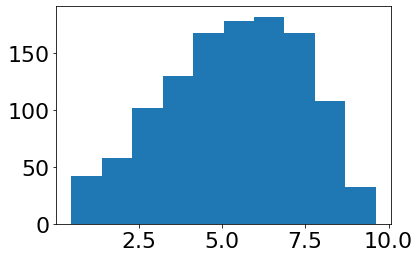

In [193]:
plt.hist((hnl_tree['VSI_LRTR3_1p0_ntuples_LNC_DVtype'].pandas.df('DV_mass')['DV_mass'].append( 
hnl_tree['VSI_LRTR3_1p0_ntuples_LNC_DVtype'].pandas.df('DV_mass')['DV_mass']))) , 


In [121]:
data_tree = uproot.open('/data/hnl/KShort/ntuples/data18/user.rnewhous.23060002._000858.tree.root')
df_data = data_tree['outTree'].pandas.df(['secVtx_VSI_LRTR3_1p0_mass'], entrystop=1000000)
df_data.columns=['DV_mass']

In [122]:
dijet_tree = uproot.open('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/user.rnewhous.23060122._000044.tree.root')
df_dijet = dijet_tree['outTree'].pandas.df(['secVtx_VSI_LRTR3_1p0_mass'], entrystop=1000000)
df_dijet.columns=['DV_mass']

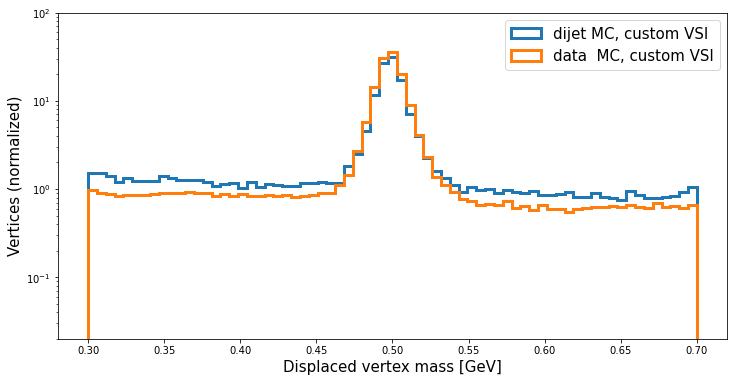

In [123]:


# J/Psi bins
bins = np.linspace(3.0, 3.2, 50) 
vert_line=3.096916
# K-Short bins
bins = np.linspace(.3, .7, 70) 
vert_line=.497648

fig = plt.figure(figsize=[12,6])
ax = plt.axes()


histoptions = { 
    'bins': bins,
    'log': True,
    'density': True, 
    'histtype': 'step',
    'linewidth': 3,
}

h = plt.hist(df_dijet['DV_mass'].array, label='dijet MC, custom VSI', **histoptions)
h = plt.hist(df_data['DV_mass'].array, label='data  MC, custom VSI', **histoptions)
# mass_cut_window = plt.axvline(x=vert_line+.01, color='purple', label='mass cut window')
plt.ylim([2e-2,1e2])
ax.legend(fontsize=15)
# plt.axvline(x=vert_line-.01, color='purple', label='mass cut window')
ax.set_xlabel('Displaced vertex mass [GeV]', fontsize=15)
ax.set_ylabel('Vertices (normalized)', fontsize=15);


In [124]:
data_tree = uproot.open('/data/hnl/KShort/histograms/data18/CR_histograms_data_kshort.root')
df_data = data_tree['VSI_LRTR3_1p0_ntuples_mass'].pandas.df(['DV_mass'], entrystop=1000000)

In [125]:
dijet_tree = uproot.open('/data/hnl/KShort/histograms/dijet_mc16e/CR_histograms_mc_kshort.root')
df_dijet = dijet_tree['VSI_LRTR3_1p0_ntuples_mass'].pandas.df(['DV_mass'], entrystop=1000000)

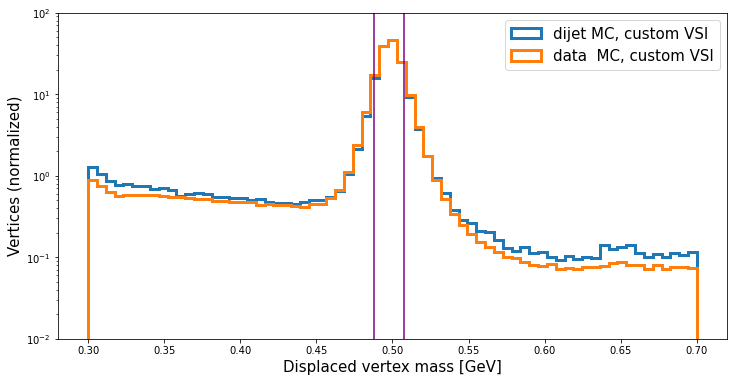

In [135]:


# J/Psi bins
bins = np.linspace(3.0, 3.2, 50) 
vert_line=3.096916
# K-Short bins
bins = np.linspace(.3, .7, 70) 
vert_line=.497648

fig = plt.figure(figsize=[12,6])
ax = plt.axes()

histoptions = { 
    'bins': bins,
    'log': True,
    'density': True, 
    'histtype': 'step',
    'linewidth': 3,
}

h = plt.hist(df_dijet['DV_mass'].array, label='dijet MC, custom VSI', **histoptions)
h = plt.hist(df_data['DV_mass'].array, label='data  MC, custom VSI', **histoptions)
plt.ylim([1e-2,1e2])
# mass_cut_window = plt.axvline(x=vert_line+.01, color='purple', label='mass cut window')
ax.legend(fontsize=15)
plt.axvline(x=vert_line-.01, color='purple', label='mass cut window')
plt.axvline(x=vert_line+.01, color='purple', label='mass cut window')
ax.set_xlabel('Displaced vertex mass [GeV]', fontsize=15)
ax.set_ylabel('Vertices (normalized)', fontsize=15);


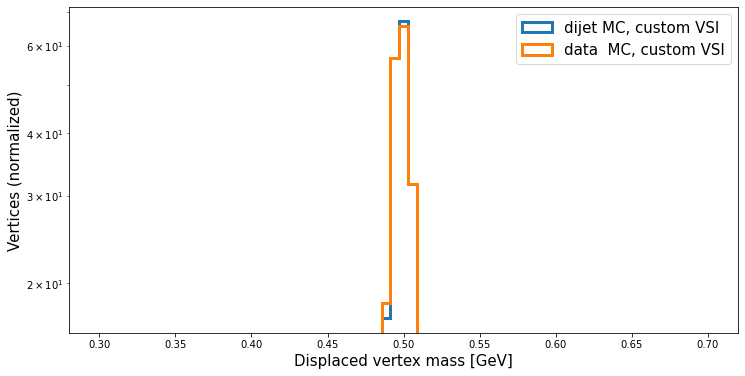

In [134]:

# J/Psi bins
bins = np.linspace(3.0, 3.2, 50) 
vert_line=3.096916
# K-Short bins
bins = np.linspace(.497648-.02, .497648+.02, 70) 
bins = np.linspace(.3, .7, 70) 
vert_line=.497648

fig = plt.figure(figsize=[12,6])
ax = plt.axes()

histoptions = { 
    'bins': bins,
    'log': True,
    'density': True, 
    'histtype': 'step',
    'linewidth': 3,
}

h = plt.hist(df_dijet.query('DV_mass > .487648 & DV_mass < .507648')['DV_mass'].array, label='dijet MC, custom VSI', **histoptions)
h = plt.hist(df_data.query('DV_mass > .487648 & DV_mass < .507648')['DV_mass'].array, label='data  MC, custom VSI', **histoptions)
# plt.ylim([1e-2,1e2])
# mass_cut_window = plt.axvline(x=vert_line+.01, color='purple', label='mass cut window')
ax.legend(fontsize=15)
ax.set_xlabel('Displaced vertex mass [GeV]', fontsize=15)
ax.set_ylabel('Vertices (normalized)', fontsize=15);